# R-Select and Median Finder Random Algorithms - Julia Version
*by Roberto Esteban López*

As part of the course, now a couple of more interesting algorithms with good bounds, that have better perfomance than the deterministic versions in practice, even thogh, their complexity in time are shared both being $O(n)$. 

R-Select is a generalized version of the median finder algorithm, which given an unsorted array $S$ it returns the $k - th$ smaller value from it, all of these without having to compute all the sorted version of $S$, which with great perfomance in $O(nlogn)$ quicksort can give. In the same abouts, the median finder is a particular version of R-Select which returns the median value of an unsorted array $S$ also in linear time. 

In [1]:
# Importing the libraries for the project
using PyCall
using Random
using Statistics
import PyPlot; const plt = PyPlot

PyPlot

In [2]:
function quicksorts(S::Array, lower::Int, upper::Int, d::Int, DEBUG::Bool=false)
    # S is the array to sort Inplace manner.
    # lower is the lower index of the part of the array to sort
    # upper is the index of the top part of the array to sort
    # d is just to return the number of the function calls it self
    
    
    if upper - lower < 1 #Base case
        if DEBUG
            println("Base case ",S," range given ",lower,", ",upper)
        end
        return S, d + 1
    else
        S_i = range(lower, stop=upper)
        # Draw a pivot in a random manner
        # p is the p-th item of S as the pivot
        p = rand(lower:upper)
        d += length(S_i)
        piv = S[p]
        for i in S_i
            d += 1 #Every iteration in this loop takes constant time.
            x = S[i]
            if (x > piv) & (i < p) # When the value is greater than the pivot and on the left of it
                
                if DEBUG
                    println("1 : ",S[lower:upper],", piv ",piv," on ", p," to ",i)
                end
                # Saving the value to move
                S[i] = piv #moving the pivot
                S[p] = x
                p = i #updating the pivot
                
                continue
            elseif (x < piv) & (i > p) # When the value is smaller than the pivot and on the right of it
                if DEBUG 
                    println("2 : ",S[lower:upper],", piv ",piv," on ", p," to ",i)
                end
                
                if (i - p) > 1
                    S[p] = x
                    aux = S[p + 1] # saving x'
                    S[p + 1] = piv #moving the pivot
                    p = p + 1 #updating the pivot
                    S[i] = aux
                else
                    S[p] = x
                    S[i] = piv
                    p = i
                end
                
                continue
            end
        end
        if DEBUG 
            println("S': ",S[lower:upper],", piv ",piv, " on ",p,". Range: ",lower,", ",upper)
        end
        S, d = quicksorts(S, lower, p, d + 1, DEBUG)
        S, d = quicksorts(S, p + 1, upper, d + 1, DEBUG)
        return S, d
    end
end

function quicksort(S::Array, iters::Bool=false, DEBUG::Bool=false)
    # Function to initialize the calls to quicksorts random-version
    # without the the rest of the arguments. 
    S, d = quicksorts(S, 1, length(S), 0, DEBUG)
    if iters
        return S, d
    else
        return S
    end
end

quicksort (generic function with 3 methods)

In [3]:
# Benchmarking the perfomance of quicksort
sizes = range(10, 2000, step=100)
samples = 50
iters_qs = zeros(Int, length(sizes), 50)
times_qs = zeros(Float64, length(sizes), 50)


for i in range(1,stop=length(sizes))
    a = shuffle(range(1, stop=10^4))[1:sizes[i]]
    for sample in range(1, stop=50)
        start = time_ns()
        _, d = quicksort(copy(a), true)
        times_qs[i, sample] = (time_ns()-start)/10^6
        iters_qs[i, sample] = d
    end
end

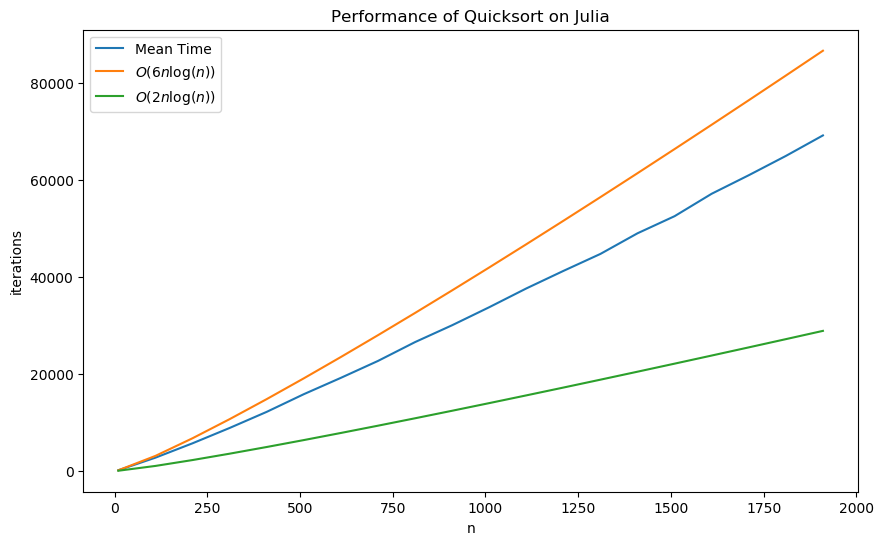

In [4]:
fig, axs = plt.subplots(figsize=(10,6))
axs.plot(sizes, mean(iters_qs, dims=2), label="Mean Time")
axs.plot(sizes, [6*x*log(x) for x in sizes], label="\$O(6n \\log(n))\$")
axs.plot(sizes, [2*x*log(x) for x in sizes], label="\$O(2n \\log(n))\$")
axs.set_xlabel("n")
axs.set_ylabel("iterations")

plt.title("Performance of Quicksort on Julia")
plt.legend()
plt.show()

## Median Finder - Random Algorithm

In [5]:
function median_random(S::Array, Iter::Bool=false, DEBUG::Bool=false, max_iters::Int=0)
    if DEBUG 
        println(S)
    end
    
    if max_iters < 1 
        vegas = true
    else
        vegas = false
    end
        
    n = length(S)
    tqrt = n^(3/4)
    sqt = sqrt(n)
    d_i = convert(Int, (floor(0.5*tqrt - sqt)))
    if d_i < 1
        d_i = 2
    end
    u_i = convert(Int, (ceil(0.5*tqrt + sqt)))
    if u_i > n
        u_i = n - 1
    end
    i = 0 #Counting iterations without the constant
    
    while true
        i += 1
        if !vegas & (i > max_iters)
            # This condition checks if the mode is not set in vegas and limit
            # the max iterations to find the median
            if DEBUG 
                print("Maximum number of iterations reached")
            end
            return None
        end
        R_l = convert(Int, ceil(tqrt))
        R = zeros(Int, R_l)
        for i in range(1, stop=R_l)
           R[i] = S[rand(1:n)] 
        end
        i += R_l
        _, d = quicksort(R, true)
        i += d
        d = R[d_i]
        u = R[u_i]
        C = []
        l_d, l_u = 0, 0
        
        for x in S # Comparing every element in S to d and u
            i += 1
            if x < d
                l_d += 1
                continue
            elseif (d <= x) & (x <= u)
                push!(C, x)
                continue
            else #if u < x only last condition left
                l_u += 1
                continue
            end
        end
        
        if DEBUG 
            print("R",R,d,u,"ld",l_d,",lu",l_u,",C",C)
        end
            
        m_ = floor(n/2)
        l_C = n - l_d - l_u
        
        if (l_d >= m_) | (l_u >= m_)
            if DEBUG 
                    println("Failed, case 1")
            end
            continue #The algorithm failed with the random choices
            
        elseif l_C > 4 * tqrt
            if DEBUG 
                    println("Failed, case 2")
            end
            continue #other case where the algorithm failed
            
        else #The algorithm was successful
            _, d = quicksort(C, true)
            i += d
            m = convert(Int, (floor(n/2) - l_d))
            
            #Saving the median
            if l_C == 1
                med = C[0]
            else
                med = C[m]
            end
            if DEBUG 
                    print(C, m)
            end
             
            #After success, return the result
            if Iter
                return med, i
            else
                return med
            end
        end
    end
end     

median_random (generic function with 4 methods)

In [6]:
# Benchmarking the perfomance of median finder 
iters_m = zeros(Int, length(sizes), 50)
times_m = zeros(Float64, length(sizes), 50)


for i in range(1,stop=length(sizes))
    a = shuffle(range(1, stop=10^4))[1:sizes[i]]
    for sample in range(1, stop=50)
        start = time_ns()
        _, d = median_random(copy(a), true)
        times_m[i, sample] = (time_ns()-start)/10^6
        iters_m[i, sample] = d
    end
end

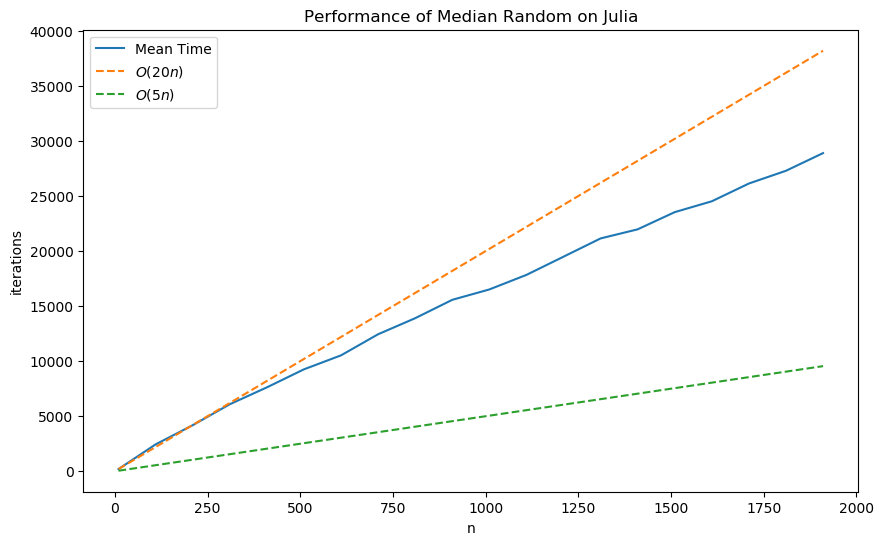

In [7]:
fig, axs = plt.subplots(figsize=(10,6))
axs.plot(sizes, mean(iters_m, dims=2), label="Mean Time")
axs.plot(sizes, [20*x for x in sizes], label="\$O(20n)\$",ls="--")
axs.plot(sizes, [5*x for x in sizes], label="\$O(5n)\$",ls="--")
axs.set_xlabel("n")
axs.set_ylabel("iterations")

plt.title("Performance of Median Random on Julia")
plt.legend()
plt.show()

## R-Select or Quickselect


In [8]:
function rs(S::Array, k::Int, lower::Int, upper::Int, d::Int, DEBUG::Bool=false)
    # R-select programm to find the k-th smaller element in an unordered array
    # Does the operation in-place, giving a partial order to the array
    # S is the array to extract the element
    # k is the desired k-1 -th smaller element in S. taking 0 the smaller due to python indexing
    # lower is the lower bound to analize the array in
    # upper is the upper bound to analize the array in
    # d is the number of calls to itself, as a function
    if upper - lower <= 1 
        if DEBUG
            println("Base case ",S," range given ",lower,", ",upper)
        end
        return S, S[k], d + 1
        
    else
        S_i = range(lower, stop=upper)
        S_i_l = upper - lower
        # Draw a pivot in a random manner
        # p is the p-th item of S as the pivot
        p = rand(lower:upper)
        d += S_i_l
        piv = S[p] #Value of the pivot from S
        for i in S_i
            d += 1 # Every operation inside this loop takes constant time
            # The use of this loop has all movements in it, with the cost of write memory access
            # To change instead of executing a single loop is better to do two.
            x = S[i]
            if (x > piv) & (i < p) # When the value is greater than the pivot and on the left of it
                # Saving the value to move
                S[i] = piv #moving the pivot
                S[p] = x
                p = i #updating the pivot
                if DEBUG
                    println("1 : ",S[lower:upper]," piv ",piv)
                end
                continue
            elseif (x < piv) & (i > p) # When the value is smaller than the pivot and on the right of it
                if (i - p) > 1
                    S[p] = x
                    aux = S[p + 1] # saving x'
                    S[p + 1] = piv #moving the pivot
                    p = p + 1 #updating the pivot
                    S[i] = aux
                else  
                    S[p] = x
                    S[i] = piv
                    p = i
                end
                if DEBUG 
                    println("2 : ",S[lower:upper]," piv ",piv)
                        end
                continue
            end
        end
        if DEBUG
            println("S': ",S[lower:upper]," piv ",piv, " on ",p," range: ",lower,", ",upper)
        end

        if p == k # Done.
            return S, piv, d + 1
        elseif p < k
            return rs(S, k, p, upper, d + 1, DEBUG)
        else #p>k is left
            return rs(S, k, lower, p, d + 1, DEBUG)
        end
    end
end

function Rselect(S::Array, k::Int, Iter::Bool=false, DEBUG::Bool=false)
    N, ans, d = rs(S, k, 1, length(S), 0, DEBUG)
    if !Iter
        return ans
    else
        return ans, d
    end 
end


Rselect (generic function with 3 methods)

In [9]:
# Comparing results from the three algorithms to give the median
i = 0
while true
    a = rand(1:10^3, 20)
    b = median_random(copy(a))
    c = Rselect(copy(a),10)
    m = quicksort(a)[10]
    #println(typeof(b),typeof(c),typeof(m))
    if (m!=b) | (m!=c) | (b!=c)
        println("Mistake on ",b,", ",c,", ",m)
        break
    end
    if i > 10^5
        println("All good")
        break
    end
    i += 1
end

All good


In [10]:
# Benchmarking the perfomance of median finder 
iters_rs = zeros(Int, length(sizes), 50)
times_rs = zeros(Float64, length(sizes), 50)


for i in range(1,stop=length(sizes))
    a = shuffle(range(1, stop=10^4))[1:sizes[i]]
    for sample in range(1, stop=50)
        start = time_ns()
        _, d = Rselect(copy(a), sizes[i] ÷ 2, true)
        times_rs[i, sample] = (time_ns()-start)/10^6
        iters_rs[i, sample] = d
    end
end

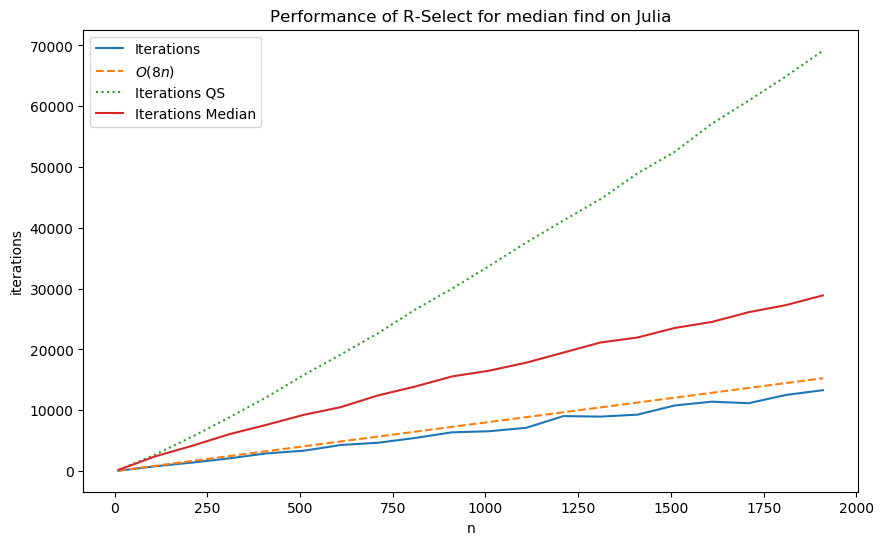

In [11]:
fig, axs = plt.subplots(figsize=(10,6))
axs.plot(sizes, mean(iters_rs, dims=2),label="Iterations")
axs.plot(sizes, [8*x for x in sizes], label="\$O(8n)\$",ls="--")
axs.plot(sizes, mean(iters_qs, dims=2), label="Iterations QS",ls=":")
axs.plot(sizes, mean(iters_m, dims=2), label="Iterations Median")
axs.set_xlabel("n")
axs.set_ylabel("iterations")

plt.title("Performance of R-Select for median find on Julia")
plt.legend()
plt.show()

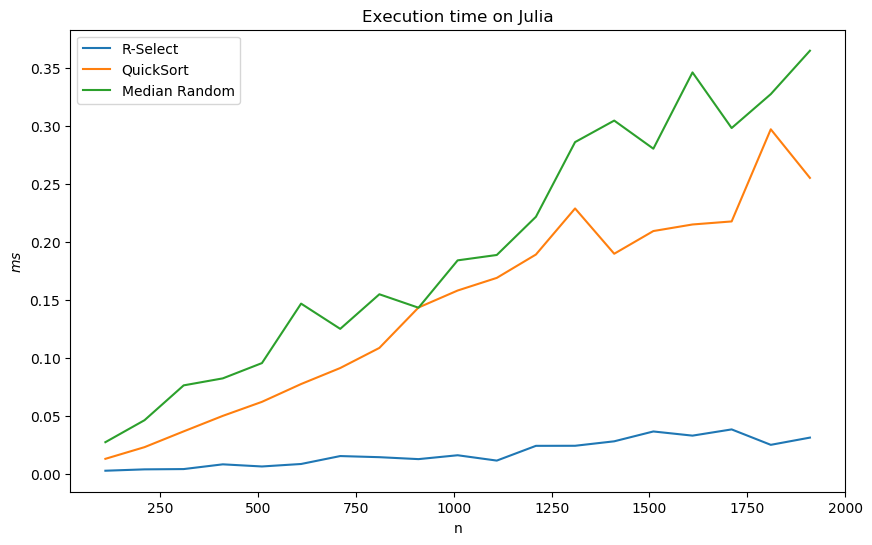

In [13]:
fig, axs = plt.subplots(figsize=(10,6))
axs.plot(sizes[2:length(sizes)], mean(times_rs[2:length(sizes)], dims=2),label="R-Select")
axs.plot(sizes[2:length(sizes)], mean(times_qs[2:length(sizes)], dims=2), label="QuickSort")
axs.plot(sizes[2:length(sizes)], mean(times_m[2:length(sizes)], dims=2), label="Median Random")
axs.set_xlabel("n")
axs.set_ylabel("\$ms\$")

plt.title("Execution time on Julia")
plt.legend()
plt.show()